In [81]:
from __future__ import print_function, division 
import numpy as np

def debug_signal_handler(signal, frame):
    import pdb
    pdb.set_trace()
import signal
signal.signal(signal.SIGINT, debug_signal_handler)

seq_size = 1000

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#https://www.biostars.org/p/710/
from itertools import groupby
def fasta_iter(fasta_name):
    """
        given a fasta file, yield tuples of (header, sequence)
    """
    fh = open(fasta_name) # file handle
    # ditch the boolean (x[0]) and just keep the header or sequence since they alternate
    fa_iter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in fa_iter:
        header = header.next()[1:].strip() # drop the ">" from the header
        seq = "".join(s.strip() for s in fa_iter.next()) # join all sequence lines to one
        yield header, seq

# take input sequence name and return the onehot encoding
def fasta_to_onehot(input_name):
    fasta_sequences = []

    fasta = fasta_iter(input_name)

    onehot = []
    for header, seq in fasta:   
        fasta_sequences.append(seq)
        onehot_seq = one_hot_encode_along_channel_axis(seq)
        onehot.append(onehot_seq)
        
    return onehot, fasta_sequences

# could be optimized, don't need onehot
'''
def get_snp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    hyp_scores = hyp_scpres[:100]
    off = int((seq_size-1)/2)
    snp_hyp = hyp_scores[:, off]

    #print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    #print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:5]=\n", snp_onehot[:5])

    snp_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        snp_scores.append(np.sum(snp_score))
    print("snp_scores done ", len(snp_scores))
    print(snp_scores[:5])
    return snp_scores
'''
def get_imp_scores(score_file, seq_file):
    hyp_scores = np.load(score_file)
    onehot, seqs = fasta_to_onehot(seq_file)
    #hyp_scores = hyp_scores[:10]
    #onehot     = onehot[:10]
    #print("onehot done ", len(onehot))
    #print("onehot[:5]=\n", onehot[:5])

    imp_scores = []
    for i in range(len(hyp_scores)):
        contrib_score = hyp_scores[i] * onehot[i]
        #imp_scores.append(np.sum(contrib_score, axis=-1))
        imp_scores.append(contrib_score)

    #print("imp_scores shape=", imp_scores[0].shape, len(imp_scores))
    #print(imp_scores[:2][:5])
    return imp_scores, seqs

def get_snp_hyp_score_diff(score_file, seq_file):
    hyp_scores = np.load(score_file)
    off = int((seq_size)/2)
    snp_hyp = hyp_scores[:, off]

    print("snp_hyp shape=", snp_hyp.shape)
    #print("snp_hyp[:5]=\n", snp_hyp[:5])

    onehot = fasta_to_onehot(seq_file)
    snp_onehot = [one_seq[off] for one_seq in onehot]
    print("onehot done ", len(onehot), snp_onehot[0].shape)
    #print("onehot[:2]=\n", snp_onehot[:2][:5])

    diff_scores = []
    for i in range(len(hyp_scores)):
        snp_score = snp_hyp[i] * snp_onehot[i]
        diff      = snp_hyp[i] - snp_score
        max_diff  = np.max(np.abs(diff), axis=-1)
        #print(diff.shape, max_diff.shape)

        diff_scores.append(max_diff)
    print("diff_scores done ", len(diff_scores))
    #print(diff_scores[:5])
    return diff_scores

def max_sub_array_sum(a, size): 
      
    max_so_far = 0
    max_ending_here = 0
      
    for i in range(0, size): 
        max_ending_here = max_ending_here + a[i] 
        if max_ending_here < 0: 
            max_ending_here = 0
          
        # Do not compare for all elements. Compare only    
        # when  max_ending_here > 0 
        elif (max_so_far < max_ending_here): 
            max_so_far = max_ending_here 
              
    return max_so_far 

weights = []
use_abs = False
def init_weights(method, win):
    global weights
    weights = np.ones(win)
    b = 0.5
    if method == "linear": 

        for i in range(int(win/3), int(win*2/3)):
            weights[i] = 1
        for i in range(int(win/3)):
            length = win/3
            step   = (1-b) / length
            weights[i] = b + i * step
            weights[win-1-i] = b + i * step            
    elif method == "uniform":
        for i in range(win):
            weights[i] = 1
    else:
        pass
    print("weights=", weights)

def center_window_sum(a, snp, win):
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    if use_abs:
        diffs = np.absolute(np.sum(a[snp][start:end], axis=-1))
    else:
        diffs = np.sum(a[snp][start:end], axis=-1)
    #print(diffs.shape)
    score = np.dot(diffs, weights)
    return score

def calc_bis_score(a, win):
    #return max_sub_array_sum(a, size)
    win_sums = []
    for snp in range(len(a)):
        win_sum = center_window_sum(a, snp, win)
        win_sums.append(win_sum)
    return win_sums

# snp_diffs[i] i= 0,1,2 are the score differences for 3 alleles
# for each allele, it stored differences for each SNP
# for each SNP, it stored differences for 1k bp surrounding the SNP, of shape (1000)
def get_diff_scores(score_prefix, seq_prefix):
    snp_alleles = {}
    snp_diffs   = {}
    snp_orig, _ = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
    print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))
    for i in range(3):
        snp_allele, _  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff
        print("snp_diff " + str(i+1) + " shape=", snp_diff[0].shape) #, "\n" , snp_diff[:2][:5])
    return snp_diffs
        
def get_bis_scores(snp_diffs, win):
    bis_scores  = {}
    for i in range(3):
        bis_scores[i] = calc_bis_score(snp_diffs[i], win)
    # elementwise max among 3 lists
    max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
    return max_bis_score


from numpy import genfromtxt
import math

def get_snp_pvals(fname):
    snp_pvals = []
    lines     = []
    with open(fname) as in_fh:
        header = next(in_fh)
        line_num = 0
        for line in in_fh:
            fields = line.split('\t')
            snp_chrom = fields[0]
            snp_pos   = int(fields[1])
            pval  = float(fields[9])
            lines.append(line)
            snp_pvals.append(-math.log(pval, 10))
            line_num += 1
    return snp_pvals, lines

weights= [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]
snp_orig shape= (1000, 4) 7138
snp_diff 1 shape= (1000, 4)
snp_diff 2 shape= (1000, 4)
snp_diff 3 shape= (1000, 4)
7138 7138


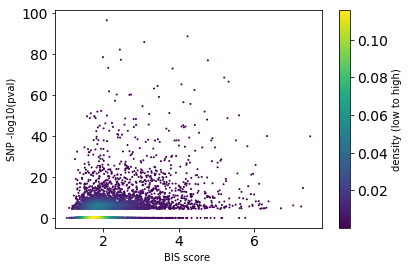

<Figure size 432x288 with 0 Axes>

In [82]:
win_size=31
init_weights("uniform", win_size)
use_abs = True

#diff_scores = get_snp_hyp_score_diff("scores/hyp_scores_task_0.npy")
snp_diffs  = get_diff_scores("scores/hyp_scores_task_0.npy", "scores/interpret.fa")
bis_scores = get_bis_scores(snp_diffs, win_size)

snp_dir  = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/"
#snp_file = "JUND_10k.txt"
#snp_file = "JUND_20k.txt"
snp_dir  = "./"
snp_file = "filter_top_bot.txt"

snp_pvals, lines = get_snp_pvals(snp_dir + snp_file)

#print(len(snp_pvals))
#print(len(bis_scores))

#%matplotlib inline
tf = 'JUND'

%matplotlib inline
import matplotlib as mpl
#mpl.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

#fig=plt.figure(figsize=(10, 8), dpi= 100)

x=bis_scores[:]
y=snp_pvals[:]
print(len(x), len(y))
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(x, y, 1, c=z, alpha=1, marker='o', label=".")
plt.xlabel("BIS score ")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()    
plt.savefig("deeplift_score_vs_pval.png")    

# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib

In [83]:
"""
import seaborn as sns
import pandas as pd
fig = plt.figure(1, figsize=(6, 6))

limit = 100
hi = [abs(i) for i in x[:limit]]
lo = [abs(i) for i in x[-limit:]]
#print(len(hi), len(lo))

median_hi = np.median(hi)
median_lo = np.median(lo)
xlabels = ["high p-value median=%f" % median_hi , "low p-value median=%f" % median_lo]
print(xlabels)
data_to_plot = pd.DataFrame({xlabels[0]:hi, xlabels[1]:lo})
data_to_plot0 = [hi, lo]
bp = plt.boxplot(data_to_plot0, labels=xlabels, widths=0.7, patch_artist=True)
#bp = plt.violinplot(data_to_plot0, widths=0.7) #, split=True)
plt.show()
fig = plt.figure(1, figsize=(6, 6))
bp = sns.violinplot(data=data_to_plot, widths=0.8, split=True)
plt.ylabel(tf + " MIS Scores")
plt.show()
"""


'\nimport seaborn as sns\nimport pandas as pd\nfig = plt.figure(1, figsize=(6, 6))\n\nlimit = 100\nhi = [abs(i) for i in x[:limit]]\nlo = [abs(i) for i in x[-limit:]]\n#print(len(hi), len(lo))\n\nmedian_hi = np.median(hi)\nmedian_lo = np.median(lo)\nxlabels = ["high p-value median=%f" % median_hi , "low p-value median=%f" % median_lo]\nprint(xlabels)\ndata_to_plot = pd.DataFrame({xlabels[0]:hi, xlabels[1]:lo})\ndata_to_plot0 = [hi, lo]\nbp = plt.boxplot(data_to_plot0, labels=xlabels, widths=0.7, patch_artist=True)\n#bp = plt.violinplot(data_to_plot0, widths=0.7) #, split=True)\nplt.show()\nfig = plt.figure(1, figsize=(6, 6))\nbp = sns.violinplot(data=data_to_plot, widths=0.8, split=True)\nplt.ylabel(tf + " MIS Scores")\nplt.show()\n'

25.770227818292017 p=1.913e-146
['significant bQTL\n median=2.162', 'insignificant bQTL\n median=1.849']


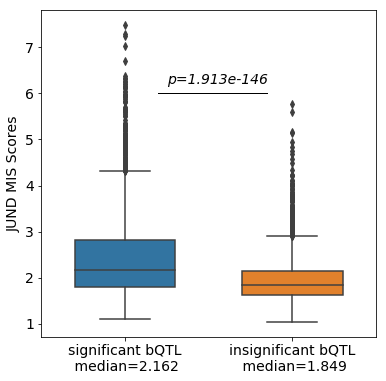

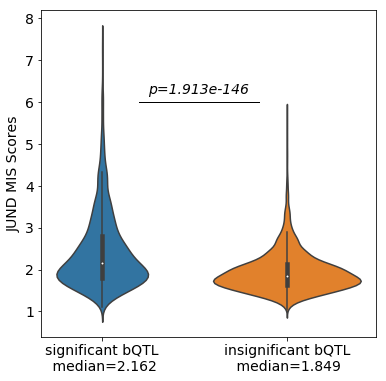

In [84]:
import seaborn as sns
import pandas as pd
import scipy
fig = plt.figure(1, figsize=(6, 6))

limit = 3569
hi = [abs(i) for i in x[:limit]]
lo = [abs(i) for i in x[-limit:]]
#print(len(hi), len(lo))

statistic, pval = scipy.stats.ranksums(hi, lo)  
pstr = "p=%.3e" % pval
print(statistic, pstr)


median_hi = np.median(hi)
median_lo = np.median(lo)
#xlabels = ["high p-value median=%f" % median_hi , "low p-value median=%f" % median_lo]
xlabels = ["significant bQTL\n median=%.3f" % median_hi , "insignificant bQTL\n median=%.3f" % median_lo]

print(xlabels)
data_to_plot = pd.DataFrame({xlabels[0]:hi, xlabels[1]:lo})
data_to_plot0 = [hi, lo]

from matplotlib import rcParams
labelsize = 14
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 

#bp = plt.boxplot(data_to_plot0, labels=xlabels, widths=0.7, patch_artist=True)
#colors=[""]
#for patch, color in zip(bp['boxes'], colors):
#    patch.set_facecolor(color)
bp = sns.boxplot(data=data_to_plot, width=0.6, order=xlabels)

plt.text(.25, 6.2, pstr, fontsize=14, style='italic')
plt.plot([.2, .85], [6,6], color='k', linewidth=1)
plt.ylabel(tf + " MIS Scores", fontsize=14)
plt.show()

fig = plt.figure(1, figsize=(6, 6))
bp = sns.violinplot(data=data_to_plot, widths=0.8, split=True, order=xlabels)
plt.text(.25, 6.2, pstr, fontsize=14, style='italic')
plt.plot([.2, .85], [6,6], color='k', linewidth=1)
plt.ylabel(tf + " MIS Scores", fontsize=14)
plt.show()


In [85]:
from modisco.visualization import viz_sequence
np.set_printoptions(suppress=True)

score_prefix = "scores/hyp_scores_task_0.npy"
seq_prefix   = "scores/interpret.fa"
snp_alleles = {}
snp_diffs   = {}
seqs        = {}
snp_orig, orig_seqs = get_imp_scores(score_prefix + "0", seq_prefix + "0") # (10k, 1000)
score_file = score_prefix + "0"
seq_file   = seq_prefix + "0"

hyp_scores = np.load(score_file)
onehot, _  = fasta_to_onehot(seq_file)

print("-----")
print(seq_file)
print(hyp_scores.shape)
print(hyp_scores[2][495:505])
print("-----")
#hyp_scores = hyp_scores[:10]
#onehot     = onehot[:10]
#print("onehot done ", len(onehot))
#print("onehot[:5]=\n", onehot[:5])

imp_scores = []
for i in range(len(hyp_scores)):
    contrib_score = hyp_scores[i] * onehot[i]
    imp_scores.append(np.sum(contrib_score, axis=-1))

'''
highlight={'r':[(10,11)]}
for start_pos, end_pos in highlight['r']:
    print(highlight['r'])
    print(start_pos, end_pos)
'''

allele_idx = [0,2,0] # A->G(1), C->A(0), C->T(2)

snp_desc   = ["SNP chr4:176935913 C->A", "SNP chr12:16789835 C->T", "SNP chr12:8608502 T->A"]

def seqs_str(seqs, snp):
    return seqs[snp][485:500] + '[' + seqs[snp][500:501] + ']' + seqs[snp][501:516]

thresh = 0.5

#print("snp_orig shape=", snp_orig[0].shape, len(snp_orig))

for i in range(3): # each i is an allele
    snp_alleles[i], seqs[i]  = get_imp_scores(score_prefix + str(i+1), seq_prefix + str(i+1)) # (10k, 1000)

for snp in range(100):

    #print(fasta_sequences[snp][495:505])
    #print(snp_orig[snp][495:505])
    line = lines[snp]
    fields = line.split('\t')
    alt_depth = int(fields[3])
    ref_depth = int(fields[4])
    print("%d %s:%s %s->%s score=%.5f %s" % (snp, fields[0], fields[1], fields[6], fields[5], x[snp], 
          "gain" if alt_depth > ref_depth else "loss"))

    if not (abs(x[snp]) > thresh or alt_depth > ref_depth):
        print(seqs_str(orig_seqs, snp), "importance score for original sequence")
        viz_sequence.plot_weights(snp_orig[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

    bis_scores  = {}

    for i in range(3): # each i is an allele
        snp_allele = snp_alleles[i]
        snp_diff    = [s - o for o,s in zip(snp_orig, snp_allele)] # (10k, 1000)
        #snp_alleles[i] = snp_allele
        snp_diffs  [i] = snp_diff

        if abs(x[snp]) > thresh or alt_depth > ref_depth:
            continue
        if fields[5] == seqs[i][snp][500]:
        #if i == allele_idx[snp]:

            print(seqs_str(seqs[i], snp), "importance score for mutated sequence ")
            #print(snp_allele[snp][495:505])
            viz_sequence.plot_weights(snp_allele[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})

            print("Mutation Impact Score ")
            #print(snp_diff[snp][495:505])
            viz_sequence.plot_weights(snp_diff[snp][490:510], figsize=(5,1), highlight={'r':[(10,11)]})
'''
for i in range(3):
    snp_diff = snp_diffs[i]
    print("allele", i)
    print(snp_diff[snp][499:502])

    win = 3
    off = int((seq_size)/2)
    start = off - int(win/2)
    end   = start + win
    score = np.sum(snp_diff[snp][start:end])
    print(start, end, score)
    
    win_sums = center_window_sum(snp_diff, snp, 3)
    print("winsums=", win_sums)
    bis_scores[i] = calc_bis_score(snp_diffs[i], 3)
    # elementwise max among 3 lists
    print("bis_scores for allele", i, bis_scores[i])

max_bis_score = [max((b1, b2, b3), key=lambda x: abs(x)) for b1, b2, b3 in zip(bis_scores[0], bis_scores[1], bis_scores[2])]
print("max_bis_score=\n", max_bis_score[:5])
'''

max_bis_score = get_bis_scores(snp_diffs)
print("max_mis_score=\n", max_bis_score[:5])


-----
scores/interpret.fa0
(7138, 1000, 4)
[[-0.083083    0.39513943  0.15885966 -0.24906111]
 [ 0.04768545 -0.03588321 -0.13228269  0.9237905 ]
 [ 0.2646838   0.5875391   0.04567852 -0.01062053]
 [ 0.1242165  -0.23469527 -0.09319643 -0.06313135]
 [-0.09743282  0.14946252  0.0193481   0.18900071]
 [ 0.09676244  0.3669164  -0.02503775  0.26206493]
 [ 0.08314678  0.02538997 -0.01233312  0.05972293]
 [ 0.00057311  0.15918663  0.06871039  0.12348285]
 [-0.04423459  0.06500112  0.16654953  0.06637295]
 [-0.0525385   0.03421386  0.08083569  0.0777092 ]]
-----
0 chr2:223885180 A->G score=2.09899 gain
1 chr11:87913325 T->C score=4.23510 loss
2 chr17:16790107 C->T score=3.09130 loss
3 chr3:46773510 G->T score=2.44501 gain
4 chr2:223885269 G->A score=1.99919 gain
5 chr3:122084529 A->G score=2.47220 gain
6 chr6:83217056 C->T score=4.77361 gain
7 chr10:97592297 C->G score=2.13869 gain
8 chr10:97592286 G->A score=3.84013 gain
9 chr14:33075706 T->C score=5.20616 gain
10 chr13:114634184 T->G score=5.

TypeError: get_bis_scores() takes exactly 2 arguments (1 given)